## Задание 1. Исследовать GAN для генерации точек на параболе

1.1
* Посмотреть что будет если подавать в качестве шума uniform распределение

1.2
* Сделать генерацию фигуры более сложной формы, например круга
* Добится сходимости

1.3 *(Дополнительно)
* Предобучить только дискриминатор (сделать его сильным критиком).
* Обучать только генератор (если критик достаточно сильный, то генератор не будет учиться)

In [80]:
import os
import numpy as np
import math
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import clear_output
from PIL import Image

import torch
import torch.nn as nn
from torch import autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Определяем модели:

In [2]:
class GenModel(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50,2))

    def forward(self, x):
        return self.model(x)

In [3]:
class DisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 15),
            nn.ReLU(),
            nn.Linear(15,1),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)

In [4]:
def get_g_batch(batch_size, latent_dim):
    g_input = torch.randn(size=(batch_size, latent_dim)).to(device)
    labels = torch.ones(size=(batch_size,)).to(device)
    return g_input, labels

In [5]:
def get_mix_batch(batch_size, latent_dim, netG):
    types_of_points = []
    
    # Generate true pairs and true labels
    x = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
    true_pair = torch.vstack((x, x*x)).T.to(device)
    true_labels = torch.ones(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((true_pair, true_labels)))
    
    # Generate fake uniform pairs and fake labels
    if True:
        x_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        y_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        fake_pair = torch.vstack((x_fake, y_fake)).T
        fake_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((fake_pair, fake_labels)))

    # Generate points from generator and set labels as fake
    if True:
        gan_pair = netG(torch.randn(size=(batch_size, latent_dim)).to(device))
        gan_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((gan_pair, gan_labels)))
    
    # Stack all types of points
    z = torch.vstack(types_of_points)
    # Shuffle
    z=z[torch.randperm(z.size()[0])]
    
    # Split back to samples and labels
    mixed_pairs = z[:, :2]
    mixed_labels = z[:, 2]
    return mixed_pairs, mixed_labels

In [6]:
def get_test_loss(model,test_loader,loss_function):
    with torch.no_grad():
        loss_test_total = 0
        for samples, labels in test_loader:
            outputs = model(samples.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss_test_total += loss.item()
        return loss_test_total/len(test_loader)

In [7]:
def netD_step(netD, batchD, loss_func, optimizer):
    samples, labels = batchD
    optimizer.zero_grad()
    outputs = netD(samples.to(device))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

In [8]:
def netG_step(netD, netG, batchG, loss_func, optimizer):
    samples, labels = batchG
    optimizer.zero_grad()
    outputs = netD(netG(samples.to(device)))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

In [44]:
def plot_gen(netG, epoch="Not provided"):
    Gin, _ = get_g_batch(1000, latent_dim)
    out = netG(Gin).cpu()
    plt.scatter(out.detach().numpy()[:, 0], out.detach().numpy()[:, 1], color="blue", s=1)
    plt.title(f'Generator points. End of epoch= {epoch+1}', fontsize=10)
    plt.axis([-1,1,-1,1])
    plt.show()

In [25]:
latent_dim = 5
batch_size = 128
batch_per_epoch = 1000
epochs = 10

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)

In [11]:
def train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            batchG = get_g_batch(batch_size, latent_dim)
            batchD = get_mix_batch(batch_size, latent_dim, netG)
            
            netD.train(True)
            netG.train(False)
            netD_step(netD, batchD, loss_func, optD)
            
            netD.train(False)
            netG.train(True)
            netG_step(netD, netG, batchG, loss_func, optG)
            
        # clear_output()
        plot_gen(netG, epoch)

### 1.1 Решение:

**Посмотреть что будет если подавать в качестве шума uniform распределение**

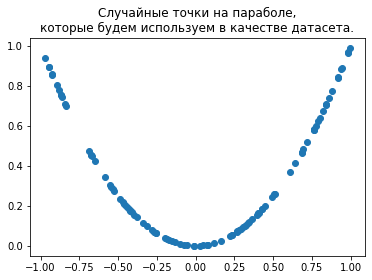

In [12]:
def gen_pair(num=100):
    x = np.random.uniform(low=-1, high=1, size=(num,))
    y = x*x
    return np.hstack((x.reshape(-1,1), y.reshape(-1,1))) # Создадим num корректных точек (x,y) на параболе

pairs = gen_pair(100)
plt.scatter(pairs[:,0], pairs[:,1])
plt.title("Случайные точки на параболе,\nкоторые будем используем в качестве датасета.")
plt.show()

In [13]:
n_batches = 10
batch_size = 128
ls = 3 # latent space

noise = np.random.uniform(size=(n_batches*batch_size, ls))
noise = torch.tensor(noise, dtype=torch.float)
print(f"NN Input: noise.shape: {noise.shape}")

xy_pair = gen_pair(num = n_batches*batch_size)
xy_pair = torch.tensor(xy_pair, dtype=torch.float)
print(f"NN Output: xy_pair.shape: {xy_pair.shape}")

dataset = TensorDataset(noise, xy_pair) # model inputs, model outputs

len_tr = int(len(dataset)*0.8)
len_tst = len(dataset) - len_tr
trainset, testset = random_split(dataset,[len_tr,len_tst])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

NN Input: noise.shape: torch.Size([1280, 3])
NN Output: xy_pair.shape: torch.Size([1280, 2])


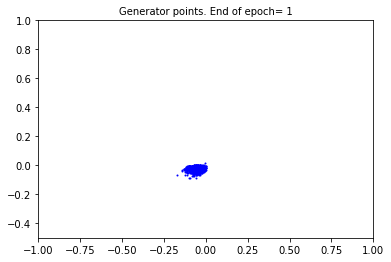

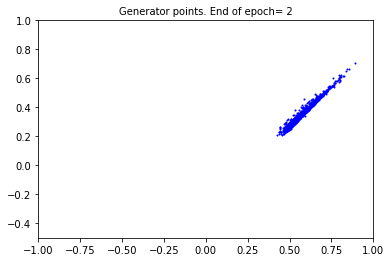

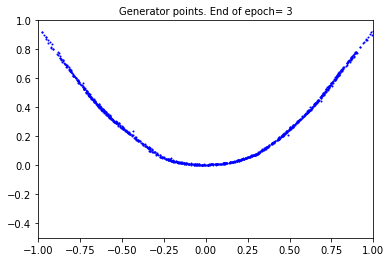

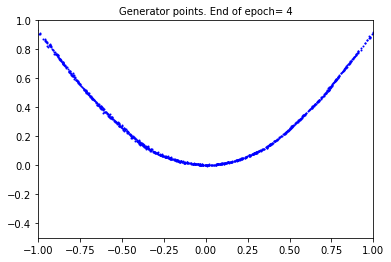

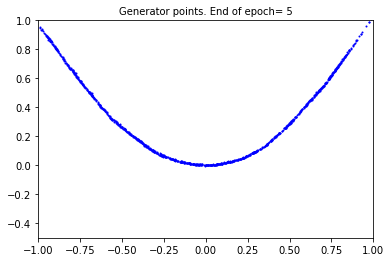

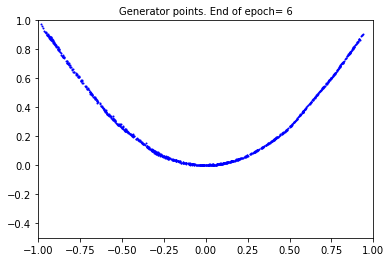

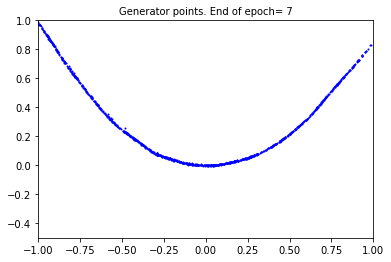

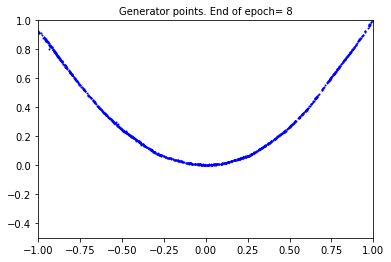

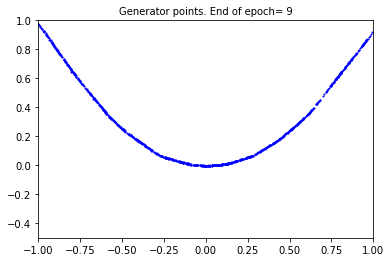

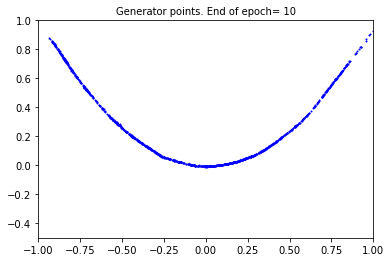

In [26]:
train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)

**Попробовать избавится от линейности на параболе (любыми известными методами)**

In [15]:
# Code here

### 1.2 Решение:

**Сделать генерацию фигуры более сложной формы, например круга**

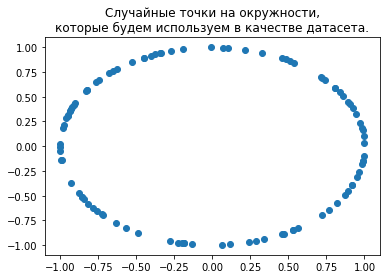

In [36]:
import math
def gen_circle(num=100):
    t = np.random.uniform(low=-3.1416, high=3.1416, size=(num,))
    x = np.cos(t)
    y = np.sin(t)
    return np.hstack((x.reshape(-1,1), y.reshape(-1,1))) # Создадим num корректных точек (x,y) на параболе

pairs = gen_circle(100)
plt.scatter(pairs[:,0], pairs[:,1])
plt.title("Случайные точки на окружности,\nкоторые будем используем в качестве датасета.")
plt.show()

In [40]:
def get_mix_batch(batch_size, latent_dim, netG):
    types_of_points = []
    
    # Generate true pairs and true labels
    t = torch.distributions.Uniform(-3.1416, +3.1416).sample((batch_size,)).to(device)
    true_pair = torch.vstack((torch.cos(t), torch.sin(t))).T.to(device)
    true_labels = torch.ones(size=(batch_size,)).unsqueeze(1).to(device)
    types_of_points.append(torch.hstack((true_pair, true_labels)))
    
    # Generate fake uniform pairs and fake labels
    if True:
        x_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        y_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        fake_pair = torch.vstack((x_fake, y_fake)).T
        fake_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((fake_pair, fake_labels)))

    # Generate points from generator and set labels as fake
    if True:
        gan_pair = netG(torch.randn(size=(batch_size, latent_dim)).to(device))
        gan_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((gan_pair, gan_labels)))
    
    # Stack all types of points
    z = torch.vstack(types_of_points)
    # Shuffle
    z=z[torch.randperm(z.size()[0])]
    
    # Split back to samples and labels
    mixed_pairs = z[:, :2]
    mixed_labels = z[:, 2]
    return mixed_pairs, mixed_labels

In [41]:
n_batches = 10
batch_size = 128
ls = 3 # latent space

noise = np.random.uniform(size=(n_batches*batch_size, ls))
noise = torch.tensor(noise, dtype=torch.float)
print(f"NN Input: noise.shape: {noise.shape}")

xy_pair = gen_circle(num = n_batches*batch_size)
xy_pair = torch.tensor(xy_pair, dtype=torch.float)
print(f"NN Output: xy_pair.shape: {xy_pair.shape}")

dataset = TensorDataset(noise, xy_pair) # model inputs, model outputs

len_tr = int(len(dataset)*0.8)
len_tst = len(dataset) - len_tr
trainset, testset = random_split(dataset,[len_tr,len_tst])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

NN Input: noise.shape: torch.Size([1280, 3])
NN Output: xy_pair.shape: torch.Size([1280, 2])


In [45]:
latent_dim = 5
batch_size = 128
batch_per_epoch = 1000
epochs = 15

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)

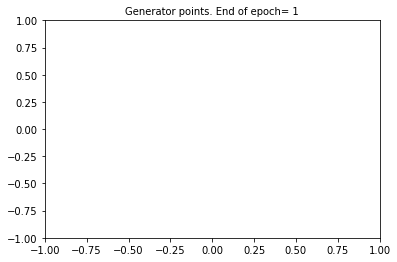

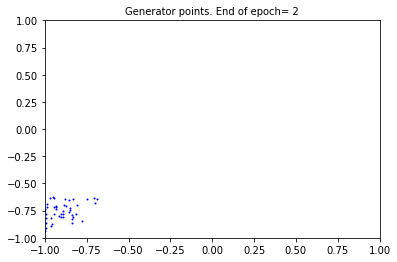

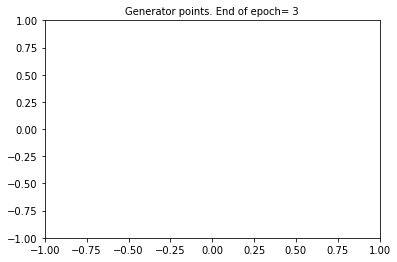

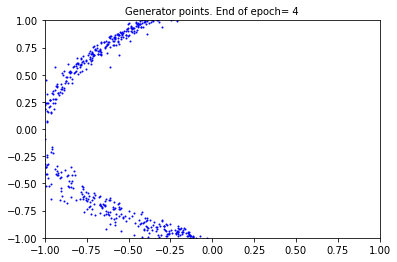

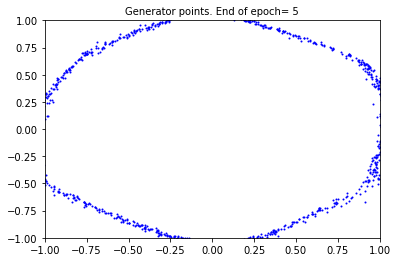

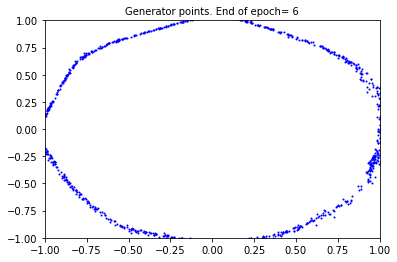

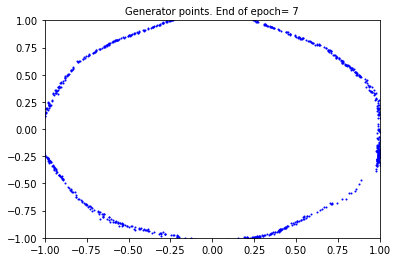

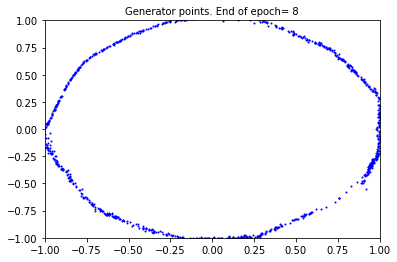

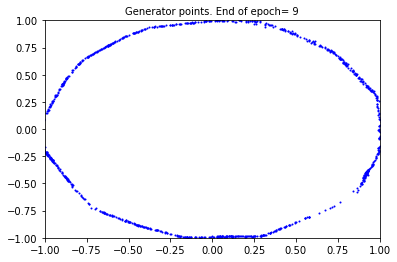

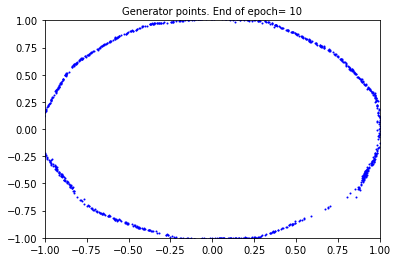

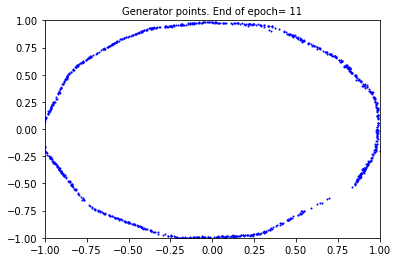

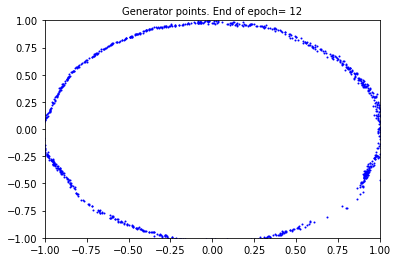

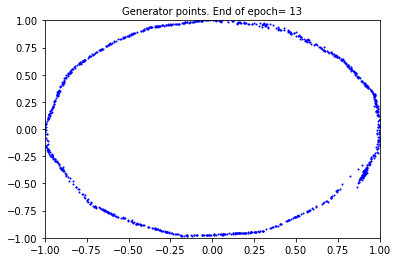

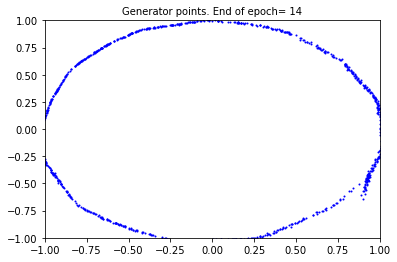

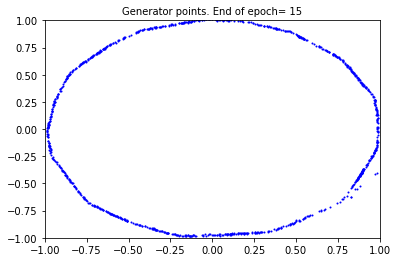

In [46]:
train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)

### 1.3 Решение:

**Предобучить только дискриминатор (сделать его сильным критиком), а потом обучать только генератор**

In [60]:
def trainD(netD, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            #print('hello')
            batchD = get_mix_batch(batch_size, latent_dim, netG)            
            netD.train(True)
            netD_step(netD, batchD, loss_func, optD)
            
        # clear_output()
        #print('Im here')
        #plot_gen(netD, epoch)

In [65]:
def trainG(netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optG):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            batchG = get_g_batch(batch_size, latent_dim)        
            netG.train(True)
            netG_step(netD,netG, batchG, loss_func, optG)
            
        # clear_output()
        plot_gen(netG, epoch)

In [63]:
def plot_gen(netG, epoch="Not provided"):
    Gin, _ = get_g_batch(1000, latent_dim)
    out = netG(Gin).cpu()
    
    plt.scatter(out.detach().numpy()[:, 0], out.detach().numpy()[:, 1], color="blue", s=1)
    plt.title(f'Generator points. End of epoch= {epoch+1}', fontsize=10)
    plt.axis([-1,1,-1,1])
    plt.show()

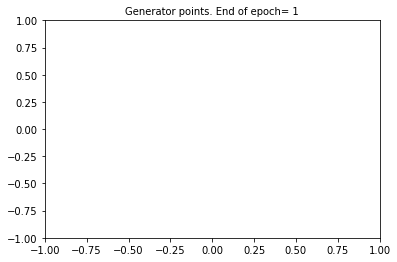

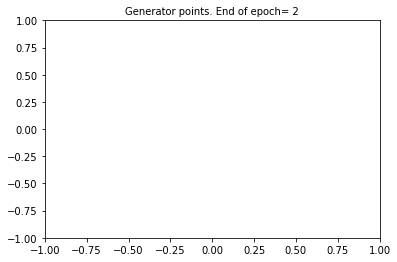

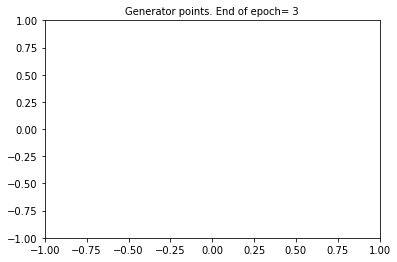

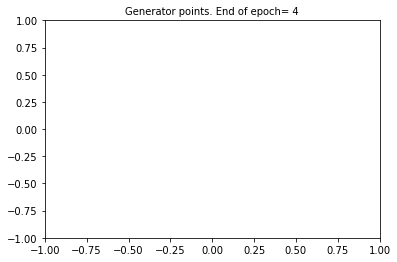

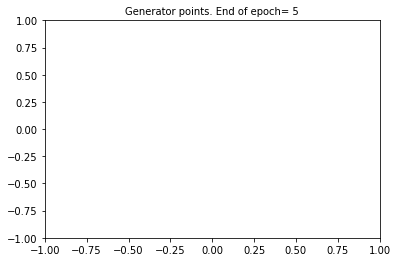

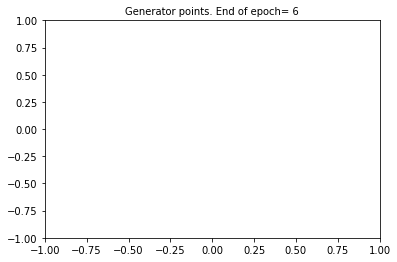

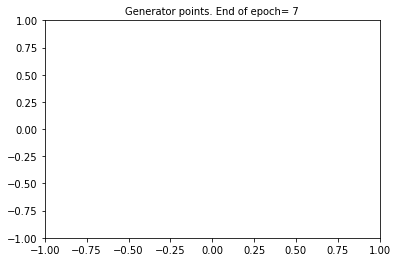

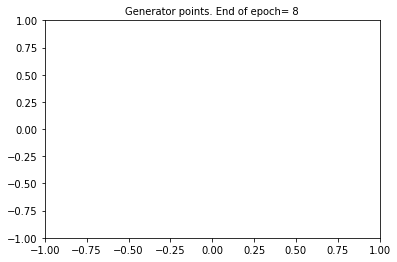

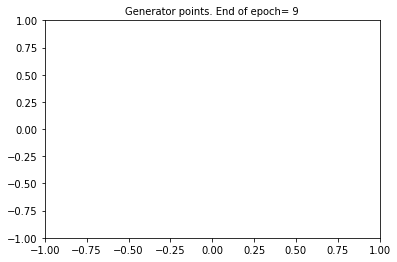

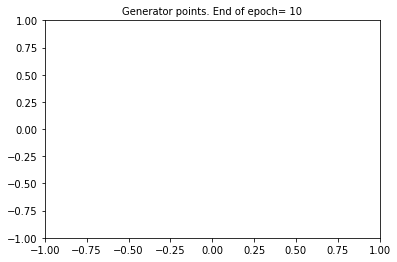

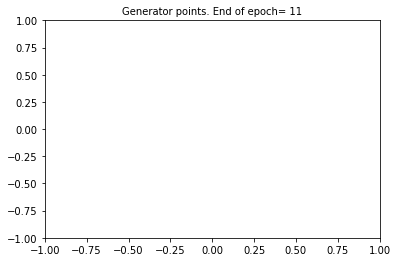

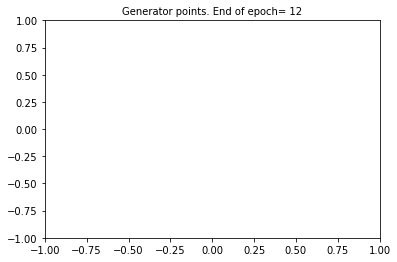

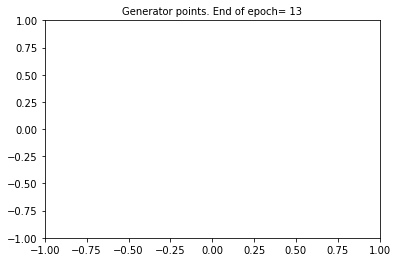

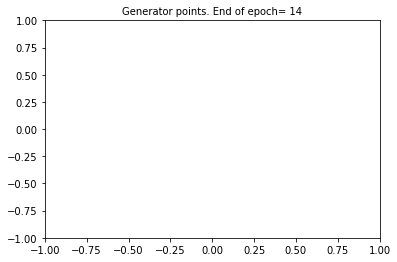

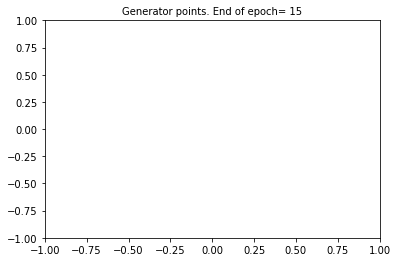

In [73]:
latent_dim = 5
batch_size = 128
batch_per_epoch = 1000
epochs = 15

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)
trainD(netD, batch_per_epoch, batch_size, latent_dim, 14, loss_func, optD)
trainG(netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optG)

## Задание 2. cGAN на датасете Fashion mnist (или MNIST)

Напишите полносвязный GAN с условием. Условием в данном случае будет являтся lablel (номер класса) цифры или вещи.

1. Сделайте эмбединг для лэйблов внутри модели
2. С помощью torch.cat добавьте этот эмбединг ко входу генератора и дискриминатора
3. Используйте такие параметры для генератора:
        self.model = nn.Sequential(
            nn.Linear(?, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
4. Используйте такую архитектуру для дискриминатора:
        self.model = nn.Sequential(
            nn.Linear(?, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

In [173]:
class Discriminator(nn.Module):
    def __init__(self, image_size = 28, channels = 1, num_classes = 10):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.main = nn.Sequential(
            nn.Linear(channels * image_size * image_size + num_classes, 1024),
     nn.LeakyReLU(0.2, inplace=True),
     nn.Dropout(0.3),
     nn.Linear(1024, 512),
     nn.LeakyReLU(0.2, inplace=True),
     nn.Dropout(0.3),
     nn.Linear(512, 256),
     nn.LeakyReLU(0.2, inplace=True),
     nn.Dropout(0.3),
     nn.Linear(256, 1),
     nn.Sigmoid())
            
    def forward(self, input, labels = None):
        input = torch.flatten(input, 1)
        conditional = self.label_embedding(labels)
        conditional_input = torch.cat([input, conditional], dim=-1)
        out = self.main(conditional_input)
        return out.squeeze()

In [174]:
class Generator(nn.Module):
    def __init__(self, image_size = 28, channels = 1, num_classes = 10):
        super(Generator, self).__init__()
        self.image_size = image_size
        self.channels = channels
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.main = nn.Sequential(
            nn.Linear(100+num_classes, 256),
     nn.LeakyReLU(0.2, inplace=True),
     nn.Linear(256, 512),
     nn.LeakyReLU(0.2, inplace=True),
     nn.Linear(512, 1024),
     nn.LeakyReLU(0.2, inplace=True),
     nn.Linear(1024, 784),
     nn.Tanh()
              )

    def forward(self, input, labels):
        conditional_input = torch.cat([input, self.label_embedding(labels)], dim=-1)
        out = self.main(conditional_input)
        return out.view(out.size(0), 28, 28)


In [112]:
?torch.cat

Код ниже желательно не изменять

In [175]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])

dataset = MNIST(root ='/content/',
                       train = True,
                       transform = transform, 
                       target_transform = None, 
                       download = True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [176]:
def get_class_name(num):
    """Вспомогательная функция возвращающая название класса по его индексу
    num - численный индекс класса"""
    class_names = dataset.class_to_idx #{название класса : индекс класса}

    key_list = list(class_names.keys())
    val_list = list(class_names.values())
    
    # print key with val 100
    position = val_list.index(num)
    print(key_list[position])

In [177]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, torch.ones(batch_size).to(device))
    g_loss.backward()
    g_optimizer.step()
    return g_loss

def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones((batch_size)).to(device))
    # train with fake images
    z = torch.randn(batch_size, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size).to(device))

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss

In [178]:
def show_gen_res(generator):
    z = torch.randn(9, 100).to(device)
    labels = torch.LongTensor(np.arange(9)).to(device)

    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

In [179]:
betas = (0.5, 0.999)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
lr = 1e-4

criterion = nn.BCELoss().to(device)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)

In [139]:
?nn.BCELoss()

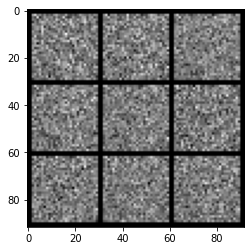

Starting epoch 0...
g_loss: 13.370627403259277, d_loss: 1.2949440479278564


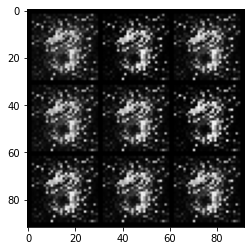

Starting epoch 1...
g_loss: 4.8637518882751465, d_loss: 0.15909725427627563


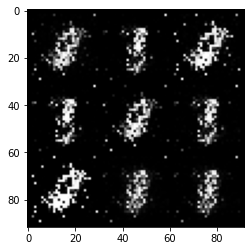

Starting epoch 2...
g_loss: 4.954113960266113, d_loss: 0.14575189352035522


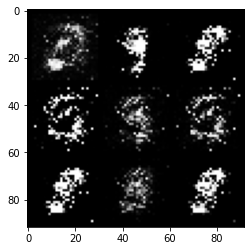

Starting epoch 3...
g_loss: 2.6928365230560303, d_loss: 0.18331995606422424


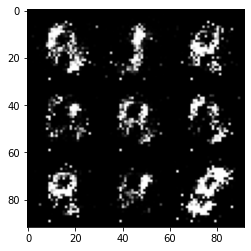

Starting epoch 4...
g_loss: 4.833922863006592, d_loss: 0.20216962695121765


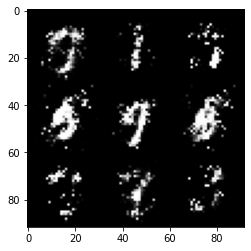

Starting epoch 5...
g_loss: 3.0258896350860596, d_loss: 0.1724299192428589


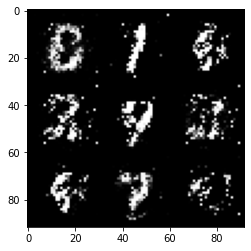

Starting epoch 6...
g_loss: 2.864863634109497, d_loss: 0.27995020151138306


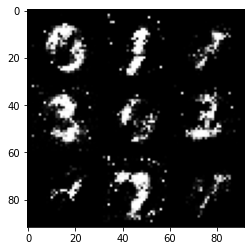

Starting epoch 7...
g_loss: 2.872654438018799, d_loss: 0.7839397192001343


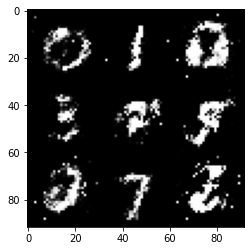

Starting epoch 8...
g_loss: 2.200531005859375, d_loss: 0.6576237678527832


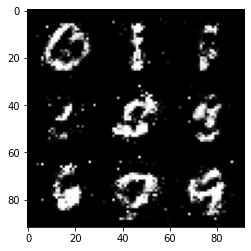

Starting epoch 9...


In [ ]:
num_epochs = 10
n_critic = 5
display_step = 300

for epoch in range(num_epochs):
    show_gen_res(generator)
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.to(device)
        labels = labels.to(device)
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
